In [1]:
#Python math
import numpy as np
from scipy import sparse
import scipy.linalg as scla

#Data analysis
import matplotlib.pyplot as plt
import networkx as nx #For graph management
%matplotlib inline

#Embedding methods
from REGAL.xnetmf import xnetmf
from REGAL.netmf import netmf

#Code for performing the various analysis and graph mining tasks
from analysis import *

# I. Introduction

Node embedding is a technique for learning feature representations of nodes in a network, with which we can perform a number of downstream data mining and machine learning tasks.  It is a powerful tool for comparing nodes in a graph--and as we will see, it can even be used to compare nodes in different graphs, or even entirely different graphs! 

The feature learning objective seems to learn "similar" features for "similar" nodes.  But what does it mean for nodes to be similar?  It turns out that there are different ways of defining node similarity, and our definition of node similarity will affect the tasks for which we can use the node embeddings.   

# II. Node Similarity and Embeddings

Let's draw a simple-looking graph, a classic example used in sociological network theory [1].  Which nodes do you think are similar? 

/System/Library/Frameworks/Python.framework/Versions/2.7/Extras/lib/python/matplotlib/collections.py:608: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if self._edgecolors_original != 'face':
/System/Library/Frameworks/Python.framework/Versions/2.7/Extras/lib/python/matplotlib/collections.py:548: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if self._edgecolors == 'face':


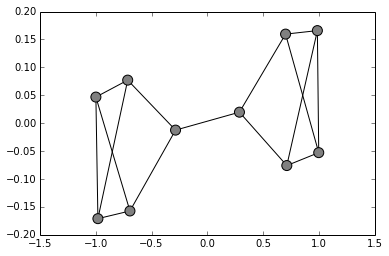

In [2]:
#Borgatti-Everett network
g_BE = nx.Graph()
g_BE.add_nodes_from(range(10))
g_BE.add_edges_from([(0, 1), (0, 2), (0,3), (1,2), (1,3), (2,4), (3,4)]) #community 1
g_BE.add_edges_from([(4,5)]) #bridge
g_BE.add_edges_from([(5,6),(5,7),(9,8),(9,7),(9,6),(8,7),(8,6)]) #community 2
pos = nx.spring_layout(g_BE, pos = {0:(0,0), 1:(0,1)})

DIM = 8
adj_BE = nx.adjacency_matrix(g_BE).toarray()

nx.draw_networkx(g_BE,pos,
                nodelist=g_BE.nodes,
                node_color = ["gray"]*10,
                node_size=100,
                with_labels = False)

**A. Node Proximity**

One way to define node similarity is in terms of node proximity.  Nodes that share an edge are in close proximity, but nodes that do not share an edge, but have many mutual neighbors with whom they both share an edge, are also in some sort of proximity.  There are many subtly different ways to precisely formalize such a proximity-based concept of node similarity, but for now we'll just illustrate the general idea.  When we color code the nodes in the graph according to their proximity, we see two distinct communities of nodes sharing the same color.  

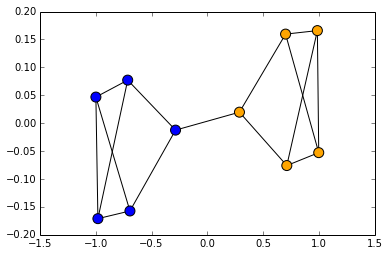

In [3]:
#Draw with community colors
community_colors = ["blue"]*5 + ["orange"]*5
nx.draw_networkx(g_BE,pos,
                nodelist=g_BE.nodes,
                node_color=community_colors,
                node_size=100,
                with_labels = False)

The embedding method NetMF [4] is designed to preserve proximities between nodes.  Two nodes have a similar feature representation if they have high "pointwise mutual information", determined by their connectivity through paths of consecutive edges of increasingly larger length.   

We'll run the NetMF to learn feature representations of each node.  Then, we'll visualize the pairwise feature correlations in a heatmap.  

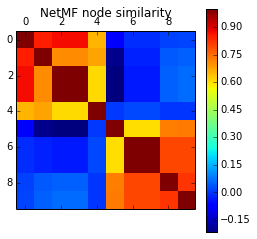

In [4]:
#Embedding: community
emb_method = "NetMF node"
netmf_emb_BE = netmf(adj_BE, dim = DIM)
visualize_emb_correlations(netmf_emb_BE, emb_method)

We see that most of the node similarities fall within the two communities we saw, consisting of the first five nodes and the second five nodes.  This is because those communities are very connected to each other, but have no direct connections to the nodes in the other communities (they only have indirect connections through paths going through the center nodes).  

**B. Structural Role Similarity**

Finding communities in networks and comparing nodes based on their proximity is very important for many tasks.  However, proximity is not the only way to compare nodes.  We can also identify nodes that are "similar" not because they are close to each other, but because they have similar patterns of behavior.  We say such nodes have similar "structural roles" in the network.  

We'll now color code the nodes of the same graph differently, so that nodes with the same structural role have the same color.  Note that nodes on opposite sides of the graph can be similar under this measure!  Indeed, you can see that the two communities in this graph are mirror images: for each node that plays a certain structural role in one community, there is a mirror image role playing an exactly corresponding structural role in the other community.  

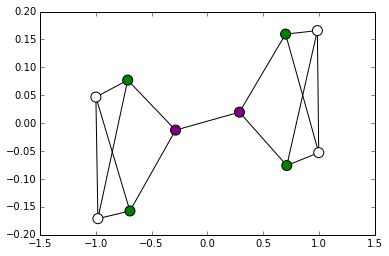

In [5]:
#Draw with role colors
role_colors = ["white","white","green","green","purple","purple","green","green","white","white"]
nx.draw_networkx(g_BE,pos,
                nodelist=g_BE.nodes,
                node_color=role_colors,
                node_size=100,
                with_labels = False)

Structural node embeddings are designed to capture these structural role equivalences in the learned node features. xNetMF [2] learns similar features that have high structural similarity, based on the distributions of connectivity patterns among their neighbors.  

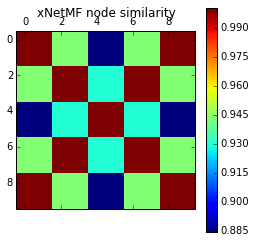

In [6]:
#Embedding: roles
emb_method = "xNetMF node"
xnetmf_emb_BE = xnetmf(adj_BE, dim = DIM)
visualize_emb_correlations(xnetmf_emb_BE, emb_method)

Indeed, we see that nodes 0-1 are considered to have perfect similarity to nodes 8-9, nodes 2-3 have perfect similarity to nodes 6-7, and nodes 4 and 5 are similar only to each other.  This exactly lines up according to the color coding displayed above.  We can even compare the roles a little more roughly.  For instance, nodes 4-5 are "bridge" nodes between communities, while nodes 0-1 and 8-9 are well connected within their communities but lie deep within their own communities: the opposite of a bridge node.  We can see from the heat map that these are the most *different* structural roles in this graph.  

# III. Multi-Network Graph Mining with Node Embeddings: Data and Problem Introductions

Now, we've illustrated two different types of node similarity within a *single* network, and we showed that each type of similarity is well captured by a different embedding method.  However, for many important problems, we have *multiple* networks, and we want to compare nodes *across* the different networks.  Which kind of node embedding will let us do this effectively?  

One graph mining task for which this is useful is the task of network alignment, where we assume there is a meaningful node correspondence between two (or more) networks, and we want to find the nodes that correspond.  For example, imagine trying to find accounts belonging to the same person on the Facebook and Twitter social networks.  We can do this with node embeddings, if the similarity of the embeddings of nodes in different networks is meaningful [2].

We may also want to compare not just individual nodes, but the networks themselves.  After all, graphs are collections of nodes, so a collection of node embedding should meaningfully describe the network.  Indeed, recent work turns node embeddings into a feature vector that describes an entire graph based on the distribution of its node embeddings in vector space [3]. 

We'll create a very simple network comparison scenario, where we create two similar networks for which we know the ground truth node alignments.  We should be able to meaningfully align nodes in these networks, and tell that they are more similar to each other than to a random network.  

In [7]:
#Embedding settings
DIM = 16

Our graph will be a collaboration network of approximately 200 jazz musicians [6].  Following a common convention of setting embedding dimension to be a power of 2, we learn 16-dimensional embeddings so that the dimensionality is clearly much smaller than the number of nodes.    

In [8]:
#Read in graph data
graph1 = nx.read_edgelist("data/out.arenas-jazz", comments="%")
adj1 = nx.adjacency_matrix(graph1).toarray()
n = graph1.number_of_nodes()

Our second graph is a copy of the first, where we randomly shuffle the node order.  This way, we know the ground-truth alignment between the nodes in the networks.  

For later, we also create a third graph that has the same number of nodes, but is otherwise randomly generated.  Each node forms an edge with each other node with probability 0.1.  While this graph is the same size, it should otherwise be considerably different, and later on, our graph comparison methods should be able to recognize this.  

We embed all the graphs at the same time by combining them as disconnected components of one large graph.  That is, the adjacency matrix of this graph is a block diagonal matrix, where each "block" is the adjacency matrix of one of the original graphs.  

In [9]:
#Make second graph that is a random permutation of the first
np.random.seed(0)
true_alignments = dict(zip(np.arange(n), np.random.permutation(np.arange(n)) ))
permutation_matrix = np.zeros((n,n)) #rows: nodes in graph 1. columns: nodes in graph 2
for i in true_alignments: permutation_matrix[i, true_alignments[i]] = 1
adj2 = permutation_matrix.T.dot(adj1).dot(permutation_matrix)

adj3 = nx.adjacency_matrix( nx.gnp_random_graph(n = n, p = 0.1, seed = 1) ).toarray()

#Combine them into one graph for ease of embedding
adj = scla.block_diag(adj1, adj2, adj3)

**A. Structural Embeddings Are Directly Comparable Across Networks**

First, we compare nodes using structural embeddings.  Just as we saw that nodes with no direct connection could have the same structural role within a network, so also nodes in different networks can have similar structural roles; it does not matter that they are not in proximity with each other.  We thus expect to find structural role-based similarities between nodes in the different networks, specifically the two that are structurally identical but with shuffled nodes.  

In [10]:
#Multi-network embeddings
emb_xnetmf = xnetmf(adj, dim = DIM)
emb1_xnetmf = emb_xnetmf[:n]
emb2_xnetmf = emb_xnetmf[n:2*n]
emb3_xnetmf = emb_xnetmf[2*n:]

*1. Visualization of Multi-Network Structural Embeddings*

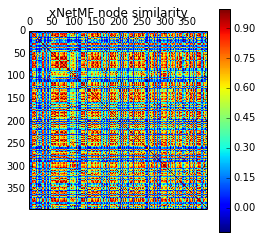

In [11]:
#Visualize multi-network embeddings
emb_method = "xNetMF node"
#focus only on comparing the first two graphs, which are permuted versions of the same graph
visualize_emb_correlations(emb_xnetmf[:2*n], emb_method)

We see that even across graphs, many nodes are recognized to be similar, just as within a graph many nodes may be different.  

*2. Network Alignment with Structural Embeddings*

In [12]:
#Score alignments: multi-network embeddings
embedding_node_alignments(emb1_xnetmf, emb2_xnetmf, true_alignments, emb_method = emb_method)

Alignment accuracy for xNetMF node embeddings: 0.965


For network alignment, this allows us to correctly align most of the nodes.  Note that there are some nodes within a graph that are structurally identical that no method can hope to meaningfully distinguish from the graph structure alone (in the example graph with the role-based coloring, consider the white nodes on either side of the graph).  Thus, we should not expect to be able to align *all* of the nodes, but we are able to align *most* of them from the structural role that they play within their own network.  

*3. Graph Comparison with Structural Embeddings*

Can we use the node embeddings to characterize the entire network itself?  We next try a method that creates graph features modeling the spatial distribution of node embeddings [3], using xNetMF features since they are comparable across graphs.  

Cell width level 0 (mean cell width 1.247)
Cell width level 1 (mean cell width 0.425)
Cell width level 2 (mean cell width 0.204)
Cell width level 3 (mean cell width 0.143)
Cell width level 4 (mean cell width 0.081)


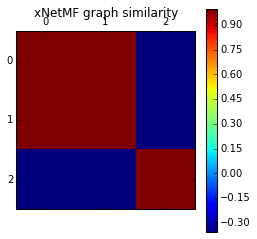

In [13]:
#Compare graphs
embedding_graph_comparison([emb1_xnetmf, emb2_xnetmf, emb3_xnetmf], emb_method = "xNetMF")

Here, we see that the two structurally identical graphs are indeed considered structurally identical based on the distribution of structural role-based embeddings they contain, as expected.  Our method also recognizes that the random graph is considerably different from both of them.  

**B. Proximity-Preserving Embeddings Are Not Directly Comparable Across Networks**

Let's see how NetMF does.  As we saw above, NetMF embeddings are designed to preserve the similarity of nodes that are in close proximity in the network (for example, connected by an edge, or by a path of consective edges).  However, nodes in different networks are not connected by a path of any length.  Note that even when we combine the graphs into one graph, the "blocks" representing the separate graphs have no edges between them.  

In [14]:
#Single network embeddings
emb_netmf = netmf(adj, dim = DIM)
emb1_netmf = emb_netmf[:n]
emb2_netmf = emb_netmf[n:2*n]
emb3_netmf = emb_netmf[2*n:]

*1. Visualization of Multi-Network Proximity-Preserving Embeddings*

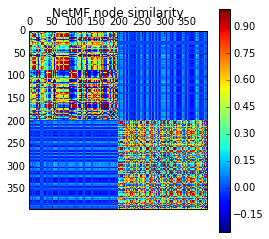

In [15]:
#Visualize single-network embeddings
emb_method = "NetMF node"
visualize_emb_correlations(emb_netmf[:2*n], emb_method)

Indeed, we see that the only meaningful node similarities NetMF finds are between nodes in the same graph.  Thus, it will be difficult to compare nodes across networks using embedding similarity.  

*2. Network Alignment with Proximity-Preserving Embeddings*

In [16]:
#Score alignments: single-network embeddings
embedding_node_alignments(emb1_netmf, emb2_netmf, true_alignments, emb_method = emb_method)

Alignment accuracy for NetMF node embeddings: 0.010


As expected, using NetMF embedding similarity, we find almost no correct cross-network node alignments.

*3. Graph Comparison with Proximity-Preserving Embeddings*

Cell width level 0 (mean cell width 0.719)
Cell width level 1 (mean cell width 0.481)
Cell width level 2 (mean cell width 0.216)
Cell width level 3 (mean cell width 0.151)
Cell width level 4 (mean cell width 0.060)


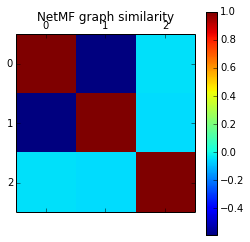

In [17]:
#Compare graphs: single-network embeddings
embedding_graph_comparison([emb1_netmf, emb2_netmf, emb3_netmf], emb_method = "NetMF")

As we can see, each graph appears very different from every other graph besides itself, even though two of the graphs are structurally identical.  Using NetMF embeddings, because these are not comparable across networks, even similar networks appear quite different.  In fact, structurally identical 

# IV. Scalability

Finally, let's compare the scalability of our two embedding methods by measuring their runtime on increasingly large graphs.  We'll just use random graphs since we don't care about the results of the embedding, just how long it takes. 

All the computations that xNetMF performs to compute (structural) node similarity are localized in the network; that is, for each node we only have to analyze a small part of the graph.  The embeddings are calculated by comparing each node to a small number of other nodes.  Between these two steps, xNetMF can scale close to linear time in the number of nodes.  

On the other hand, NetMF requires dense matrix operations to compute node similarity and to learn the embeddings via singular value decomposition.  Although the matrix subroutines it uses (like matrix multiplication, SVD) are heavily optimized and can perform competitively on small graphs, the scalability makes it much more time and memory intensive as the graph size increases.  (Note: the implemention here is based on the one released by the authors, but could be optimized further.  Furthermore, the authors have subsequently developed a sparse version of NetMF [5] that can scale to much larger graphs.)

Embedded graph with 50 nodes in 0.015 seconds using NetMF
Embedded graph with 50 nodes in 0.011 seconds using xNetMF
Embedded graph with 158 nodes in 0.027 seconds using NetMF
Embedded graph with 158 nodes in 0.029 seconds using xNetMF
Embedded graph with 500 nodes in 0.150 seconds using NetMF
Embedded graph with 500 nodes in 0.111 seconds using xNetMF
Embedded graph with 1581 nodes in 1.511 seconds using NetMF
Embedded graph with 1581 nodes in 0.411 seconds using xNetMF
Embedded graph with 5000 nodes in 18.304 seconds using NetMF
Embedded graph with 5000 nodes in 1.207 seconds using xNetMF


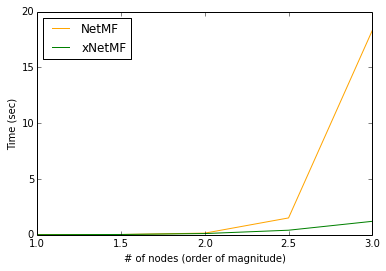

In [18]:
#Scalability
import time

DIM = 16
graph_sizes = np.arange(1,3.5,0.5) #exponents of number of nodes
times_netmf = []
times_xnetmf = []
for magnitude in graph_sizes:
    n = int(5*10**magnitude) #number of nodes
    p = 5.0/n #each node has expected degree 5
    adj = nx.adjacency_matrix( nx.gnp_random_graph(n = n, p = p, seed = 1) ).toarray()
    
    #NetMF embedding
    before_netmf = time.time()
    netmf_emb = netmf(adj, dim = DIM)
    netmf_time = time.time() - before_netmf
    times_netmf.append(netmf_time)
    print("Embedded graph with %d nodes in %.3f seconds using NetMF" % (n, netmf_time))
    
    #xNetMF embedding
    before_xnetmf = time.time()
    xnetmf_emb = xnetmf(adj, dim = DIM)
    xnetmf_time = time.time() - before_xnetmf
    times_xnetmf.append(xnetmf_time)
    print("Embedded graph with %d nodes in %.3f seconds using xNetMF" % (n, xnetmf_time))
    
#Plot the timing results    
plt.plot(graph_sizes, times_netmf, color = "orange", label = 'NetMF')
plt.plot(graph_sizes, times_xnetmf, color = "green", label = 'xNetMF')
plt.xlabel("# of nodes (order of magnitude)")
plt.ylabel("Time (sec)")
plt.legend(loc="upper left")
plt.show()

Graphs with thousands of nodes are small enough that we won't all have to sit awkwardly waiting for long :) but large enough to demonstrate the trend that the asymptotic complexity analysis of each method would predict.  

# IV. Conclusion

This tutorial illustrates node embeddings, which are techniques for learning feature representations of nodes in networks such that similar nodes have similar features.  We considered two different types of node similarity: node proximity and node structural similarity.  Within a single network, these capture different valid notions of node similarity.  However, with structural similarity, we can also compare nodes across networks, which are not in proximity.  This allows us to use structural node embeddings to develop solutions to graph mining problems defined over multiple networks, such as network alignment and graph comparison.  

References: 

[1] Borgatti, Stephen P., and Martin G. Everett. "Notions of position in social network analysis." Sociological methodology (1992): 1-35.

[2] Heimann, Mark, et al. "Regal: Representation learning-based graph alignment." Proceedings of the 27th ACM international conference on information and knowledge management. 2018.

[3] Heimann, Mark, Tara Safavi, and Danai Koutra. "Distribution of node embeddings as multiresolution features for graphs." 2019 IEEE International Conference on Data Mining (ICDM). IEEE, 2019.

[4] Qiu, Jiezhong, et al. "Network embedding as matrix factorization: Unifying deepwalk, line, pte, and node2vec." Proceedings of the Eleventh ACM International Conference on Web Search and Data Mining. 2018.

[5] Qiu, Jiezhong, et al. "Netsmf: Large-scale network embedding as sparse matrix factorization." The World Wide Web Conference. 2019.

[6] Gleiser, Pablo M., and Leon Danon. "Community structure in jazz." Advances in complex systems 6.04 (2003): 565-573.